In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# @title
!unzip /content/gdrive/MyDrive/Orinson\ Tech/Object\ Detection/VOC-2012.zip

Archive:  /content/gdrive/MyDrive/Orinson Tech/Object Detection/VOC-2012.zip
replace dataset-copy/Annotations/2007_000027.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Preparation

In [ ]:
import os
import json
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

In [ ]:
# Define the mapping of class names to category IDs
class_mapping = {
    "person": 1,
    "bird": 2,
    "cat": 3,
    "cow": 4,
    "dog": 5,
    "horse": 6,
    "sheep": 7,
    "aeroplane": 8,
    "bicycle": 9,
    "boat": 10,
    "bus": 11,
    "car": 12,
    "motorbike": 13,
    "train": 14,
    "bottle": 15,
    "chair": 16,
    "dining table": 17,
    "potted plant": 18,
    "sofa": 19,
    "tv/monitor": 20
}

## Convert XML to COCO format

In [ ]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    objects = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        category_id = class_mapping.get(label, None)
        if category_id is None:
            continue  # Skip if label not in the mapping
        xmin = int(float(obj.find('bndbox/xmin').text))
        ymin = int(float(obj.find('bndbox/ymin').text))
        xmax = int(float(obj.find('bndbox/xmax').text))
        ymax = int(float(obj.find('bndbox/ymax').text))
        objects.append({
            "category_id": category_id,
            "bbox": [xmin, ymin, xmax - xmin, ymax - ymin],
            "area": (xmax - xmin) * (ymax - ymin),
            "iscrowd": 0
        })

    return {
        "file_name": filename,
        "height": height,
        "width": width,
        "annotations": objects
    }

In [ ]:
def convert_voc_to_coco(images_folder, annotations_folder, output_json):
    coco_format = {"images": [], "annotations": [], "categories": []}

    # Add all categories to the coco_format
    for class_name, class_id in class_mapping.items():
        coco_format["categories"].append({"id": class_id, "name": class_name})

    image_id = 1
    annotation_id = 1

    for xml_file in tqdm(os.listdir(annotations_folder)):
        if xml_file.endswith('.xml'):
            image_info = parse_voc_xml(os.path.join(annotations_folder, xml_file))
            coco_format["images"].append({
                "id": image_id,
                "file_name": image_info["file_name"],
                "height": image_info["height"],
                "width": image_info["width"]
            })
            for ann in image_info["annotations"]:
                ann["image_id"] = image_id
                ann["id"] = annotation_id
                coco_format["annotations"].append(ann)
                annotation_id += 1
            image_id += 1

    with open(output_json, 'w') as f:
        json.dump(coco_format, f)

In [ ]:
# Convert VOC to COCO format
convert_voc_to_coco('/content/dataset-copy/JPEGImages', '/content/dataset-copy/Annotations', '/content/dataset-copy/output.json')

100%|██████████| 17125/17125 [00:01<00:00, 10088.15it/s]


## Sample Data

In [ ]:
import random
import json
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Define the mapping of class names to category IDs
class_mapping = {
    1: "person",
    2: "bird",
    3: "cat",
    4: "cow",
    5: "dog",
    6: "horse",
    7: "sheep",
    8: "aeroplane",
    9: "bicycle",
    10: "boat",
    11: "bus",
    12: "car",
    13: "motorbike",
    14: "train",
    15: "bottle",
    16: "chair",
    17: "dining table",
    18: "potted plant",
    19: "sofa",
    20: "tv/monitor"
}

In [ ]:
def load_coco_annotations(coco_json, image_ids):
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    annotations = []
    images_info = []
    for image_id in image_ids:
        ann = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
        img_info = next(img for img in coco_data['images'] if img['id'] == image_id)
        annotations.append(ann)
        images_info.append(img_info)

    return annotations, images_info

In [ ]:
def draw_bounding_boxes(image_path, annotations):
    image = cv2.imread(image_path)
    for ann in annotations:
        bbox = ann['bbox']
        x_min, y_min, width, height = map(int, bbox)
        x_max = x_min + width
        y_max = y_min + height

        # Get the label name using the category_id from the annotation
        category_id = ann['category_id']
        label = class_mapping[category_id]

        # Draw the bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Draw the label name above the box
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [ ]:
def show_random_images_in_grid(coco_json, images_folder, grid_size=4):
    with open(coco_json, 'r') as f:
        coco_data = json.load(f)

    # Get random image IDs
    image_ids = random.sample([img['id'] for img in coco_data['images']], grid_size * grid_size)

    annotations, images_info = load_coco_annotations(coco_json, image_ids)

    plt.figure(figsize=(20, 20))

    for i, (ann, img_info) in enumerate(zip(annotations, images_info)):
        image_with_boxes = draw_bounding_boxes(f"{images_folder}/{img_info['file_name']}", ann)

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.show()

In [ ]:
# Show random images in a 4x4 grid
show_random_images_in_grid('/content/dataset-copy/output.json', '/content/dataset-copy/JPEGImages', grid_size=4)

# Pretrained MobileNet SSD CAFFE Model

- **Caffe (Convolutional Architecture for Fast Feature Embedding)** is a deep learning framework for creating image classification and image segmentation models. Initially, users can create and save their models as plain text PROTOTXT files. After the model is trained and refined using Caffe, the program saves the trained model as a CAFFEMODEL file.

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

- MobileNetSSD protext file and caffemodel file can be downloaded from here -:https://github.com/djmv/MobilNet_SSD_opencv/blob/master/MobileNetSSD_deploy.prototxt

In [ ]:
# Paths to the prototxt and caffe model files
prototxt = "/content/dataset-copy/MobileNetSSD_deploy.prototxt"
caffe_model = "/content/dataset-copy/MobileNetSSD_deploy.caffemodel"

In [ ]:
# Load the pre-trained MobileNet SSD model
net = cv2.dnn.readNetFromCaffe(prototxt, caffe_model)

In [ ]:
# Dictionary with object class IDs and names (COCO classes)
classNames = {
    0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat',
    5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair',
    10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse',
    14: 'motorbike', 15: 'person', 16: 'pottedplant',
    17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'
}

In [ ]:
# Directory containing images
images_folder = "/content/dataset-copy/test_image"  # Update with your image directory

# Directory for saving output images
output_folder = "/content/dataset-copy/output"
os.makedirs(output_folder, exist_ok=True)

# List to hold the paths of saved images
saved_images = []

In [ ]:
# Iterate over all image files in the directory
for image_file in os.listdir(images_folder):
    # Construct the full image path
    image_path = os.path.join(images_folder, image_file)

    # Read the image
    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Failed to read image: {image_path}")
        continue

    # Get image dimensions
    height, width = frame.shape[:2]

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/127.5, size=(300, 300), mean=(127.5, 127.5, 127.5), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward()

    # Loop over the detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            class_id = int(detections[0, 0, i, 1])
            x_top_left = int(detections[0, 0, i, 3] * width)
            y_top_left = int(detections[0, 0, i, 4] * height)
            x_bottom_right = int(detections[0, 0, i, 5] * width)
            y_bottom_right = int(detections[0, 0, i, 6] * height)

            # Draw bounding box
            cv2.rectangle(frame, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)

            if class_id in classNames:
                label = f"{classNames[class_id]}: {confidence:.2f}"
                # Draw label background
                (w, h), t = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                y_top_left = max(y_top_left, h)
                cv2.rectangle(frame, (x_top_left, y_top_left - h), (x_top_left + w, y_top_left + t), (0, 0, 0), cv2.FILLED)
                # Put label text
                cv2.putText(frame, label, (x_top_left, y_top_left), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))

    # Save the result
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, frame)
    saved_images.append(output_path)  # Add to list of saved images
    print(f"Processed and saved: {output_path}")

# Display a 3x3 grid of sample images
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for ax, img_path in zip(axs.flatten(), saved_images[:9]):  # Display only up to 9 images
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    ax.imshow(img_rgb)
    ax.axis('off')
plt.show()

Processed and saved: /content/dataset-copy/output/1.jpg
Processed and saved: /content/dataset-copy/output/9.jpeg
Processed and saved: /content/dataset-copy/output/7.png
Processed and saved: /content/dataset-copy/output/5.jpeg
Processed and saved: /content/dataset-copy/output/6.jpg
Processed and saved: /content/dataset-copy/output/4.jpg
Processed and saved: /content/dataset-copy/output/3.jpg
Processed and saved: /content/dataset-copy/output/10.jpg
Processed and saved: /content/dataset-copy/output/8.png
Processed and saved: /content/dataset-copy/output/2.jpg


# Resnet50 Faster-RCNN

### Import Libraries

In [ ]:
# !pip install albumentations --user

In [ ]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler
from tqdm import tqdm

In [ ]:
BASE_PATH = "/content/dataset-copy"
XML_PATH = os.path.join(BASE_PATH, "Annotations")
IMG_PATH = os.path.join(BASE_PATH, "JPEGImages")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

### Extract Info from XML file

In [ ]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""

        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(np.float32(bndbox.find("ymin").text)))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)

### XML to Dataframe

In [ ]:
def xml_files_to_df(xml_files):

    """"Return pandas dataframe from list of XML files."""

    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in tqdm(xml_files):
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}

    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()

    return df

df = xml_files_to_df(XML_FILES)
df.head()

100%|██████████| 17125/17125 [00:01<00:00, 10276.34it/s]


image_id   names                 boxes  \
0  2008_005832.jpg     car      [1, 88, 69, 147]   
1  2008_005832.jpg     car  [160, 127, 289, 228]   
2  2008_005832.jpg  person    [48, 94, 109, 311]   
3  2008_005832.jpg  person    [96, 58, 178, 314]   
4  2008_005832.jpg     car   [237, 90, 289, 140]   

                                            xml_path  \
0  /content/dataset-copy/Annotations/2008_005832.xml   
1  /content/dataset-copy/Annotations/2008_005832.xml   
2  /content/dataset-copy/Annotations/2008_005832.xml   
3  /content/dataset-copy/Annotations/2008_005832.xml   
4  /content/dataset-copy/Annotations/2008_005832.xml   

                                           img_path  
0  /content/dataset-copy/JPEGImages/2008_005832.jpg  
1  /content/dataset-copy/JPEGImages/2008_005832.jpg  
2  /content/dataset-copy/JPEGImages/2008_005832.jpg  
3  /content/dataset-copy/JPEGImages/2008_005832.jpg  
4  /content/dataset-copy/JPEGImages/2008_005832.jpg

In [ ]:
# check values for per class
df['names'].value_counts()

names
person         17401
chair           3056
car             2492
dog             1598
bottle          1561
cat             1277
bird            1271
pottedplant     1202
sheep           1084
boat            1059
aeroplane       1002
tvmonitor        893
sofa             841
bicycle          837
horse            803
motorbike        801
diningtable      800
cow              771
train            704
bus              685
Name: count, dtype: int64

In [ ]:
# remove .jpg extension from image_id
df['img_id'] = df['image_id'].apply(lambda x:x.split('.')).map(lambda x:x[0])
df.drop(columns=['image_id'], inplace=True)
df.head()

names                 boxes  \
0     car      [1, 88, 69, 147]   
1     car  [160, 127, 289, 228]   
2  person    [48, 94, 109, 311]   
3  person    [96, 58, 178, 314]   
4     car   [237, 90, 289, 140]   

                                            xml_path  \
0  /content/dataset-copy/Annotations/2008_005832.xml   
1  /content/dataset-copy/Annotations/2008_005832.xml   
2  /content/dataset-copy/Annotations/2008_005832.xml   
3  /content/dataset-copy/Annotations/2008_005832.xml   
4  /content/dataset-copy/Annotations/2008_005832.xml   

                                           img_path       img_id  
0  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832  
1  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832  
2  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832  
3  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832  
4  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832

In [ ]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names']) + 1
# df['labels'] = enc.fit_transform(df['names'])
# df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels'])))

In [ ]:
classes = df[['names','labels']].value_counts()
classes

names        labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
Name: count, dtype: int64

In [ ]:
# make dictionary for class objects so we can call objects by their keys.
classes= {
    1:'aeroplane',
    2:'bicycle',
    3:'bird',
    4:'boat',
    5:'bottle',
    6:'bus',
    7:'car',
    8:'cat',
    9:'chair',
    10:'cow',
    11:'diningtable',
    12:'dog',
    13:'horse',
    14:'motorbike',
    15:'person',
    16:'pottedplant',
    17:'sheep',
    18:'sofa',
    19:'train',
    20:'tvmonitor'}

In [ ]:
# Initialize columns for bounding box coordinates
df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

# Extract bounding box coordinates from the 'boxes' column
# Create lists to hold the coordinates
xmins = []
ymins = []
xmaxs = []
ymaxs = []

# Iterate through the 'boxes' column to fill the lists
for box in df['boxes']:
    xmin, ymin, xmax, ymax = box
    xmins.append(xmin)
    ymins.append(ymin)
    xmaxs.append(xmax)
    ymaxs.append(ymax)

# Assign the lists to the DataFrame columns
df['xmin'] = xmins
df['ymin'] = ymins
df['xmax'] = xmaxs
df['ymax'] = ymaxs

# Drop the original 'boxes' column
df.drop(columns=['boxes'], inplace=True)

# Convert the bounding box coordinate columns to float
df['xmin'] = df['xmin'].astype(np.float32)
df['ymin'] = df['ymin'].astype(np.float32)
df['xmax'] = df['xmax'].astype(np.float32)
df['ymax'] = df['ymax'].astype(np.float32)

In [ ]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

xml_path  \
0  /content/dataset-copy/Annotations/2008_005832.xml   
1  /content/dataset-copy/Annotations/2008_005832.xml   
2  /content/dataset-copy/Annotations/2008_005832.xml   
3  /content/dataset-copy/Annotations/2008_005832.xml   
4  /content/dataset-copy/Annotations/2008_005832.xml   

                                           img_path       img_id  labels  \
0  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832       7   
1  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832       7   
2  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832      15   
3  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832      15   
4  /content/dataset-copy/JPEGImages/2008_005832.jpg  2008_005832       7   

    xmin   ymin   xmax   ymax  
0    1.0   88.0   69.0  147.0  
1  160.0  127.0  289.0  228.0  
2   48.0   94.0  109.0  311.0  
3   96.0   58.0  178.0  314.0  
4  237.0   90.0  289.0  140.0

In [ ]:
len(df['img_id'].unique())

17125

### Splitting dataset for train and valid

In [ ]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4000:]
train_ids = image_ids[:-4000]
len(train_ids)

13125

In [ ]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((9364, 8), (30774, 8))

In [ ]:
class DATASET(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values


        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

            return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DATASET(train_df, IMG_PATH , get_transform_train())
valid_dataset = DATASET(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/root/.local/lib/python3.10/site-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


### View Sample Images

ValueError: num must be an integer with 1 <= num <= 4, not 5

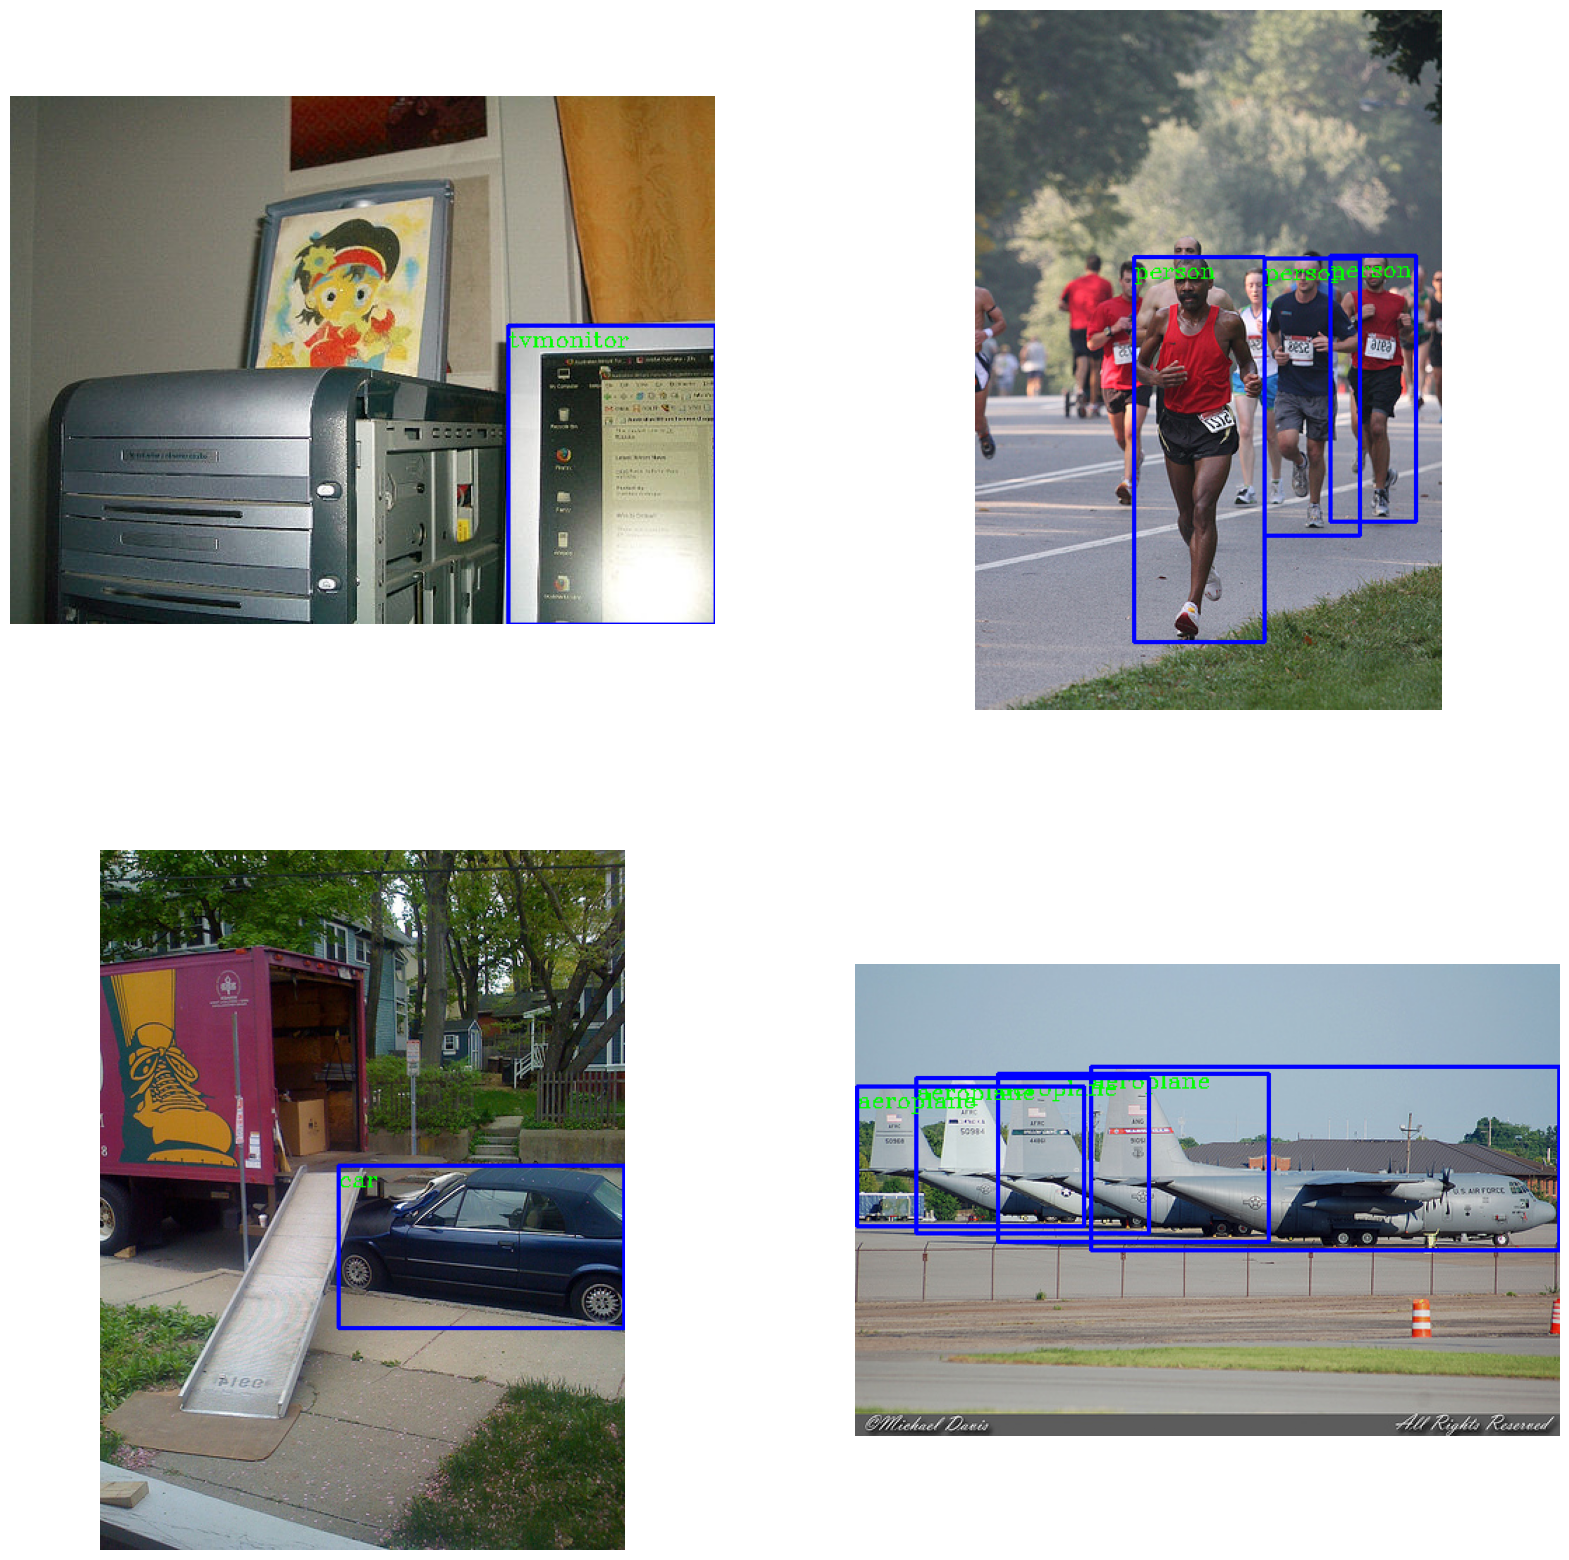

In [ ]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#### Module for Model Training

In [ ]:
# !pip install -U git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

In [ ]:
# !git clone https://github.com/pytorch/vision.git

In [ ]:
# Change directory to 'vision' and copy necessary files to the parent directory
# !cd vision && copy references\detection\utils.py ..\ && copy references\detection\transforms.py ..\ && copy references\detection\coco_eval.py ..\ && copy references\detection\engine.py ..\ && copy references\detection\coco_utils.py ..\

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
# !pip uninstall torch torchvision
# !pip install torch torchvision



In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
# Custom training loop
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    for iteration, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if iteration % print_freq == 0:
            print(f'Epoch: [{epoch}], Iteration: [{iteration}], Loss: {losses.item()}')

# Custom evaluation loop
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)
            # Process predictions and compare with targets to compute metrics


In [ ]:
# Training and evaluation
num_epochs = 1
train_one_epoch(model, optimizer, train_data_loader, device, num_epochs, print_freq=10)
lr_scheduler.step()
evaluate(model, valid_data_loader, device=device)

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

### Model Testing

In [ ]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "../input/fasterrcnn/faster_rcnn_state.pth"

num_classes = 21

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [ ]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)

    model.eval()

    detection_threshold = 0.70

    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()

    return names, boxes, sample

In [ ]:
pred_path = "/content/dataset-copy/test_image"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

# MobileNet Faster RCNN Model

### Importing Required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)


2.4.0+cu121
0.19.0+cu121


In [ ]:
from pycocotools.coco import COCO

# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
# Define the custom dataset class
class Dataset(datasets.VisionDataset):
    def __init__(self, root, transforms=None):
        super().__init__(root)
        self.coco = COCO(os.path.join(root, "output.json"))  # Adjust the path to your annotations file
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
      id = self.ids[index]
      image = self._load_image(id)
      target = self._load_target(id)

      boxes = [t['bbox'] for t in target]  # Format for Albumentations
      labels = [t['category_id'] for t in target]

      # Filter out invalid boxes and labels
      valid_boxes = []
      valid_labels = []
      for box, label in zip(boxes, labels):
          xmin, ymin, xmax, ymax = box
          if xmin < xmax and ymin < ymax:  # Ensure positive width and height
              valid_boxes.append(box)
              valid_labels.append(label)

      # Debugging: Print the shapes and types
      print(f"Image shape: {image.shape}, Type: {type(image)}")
      print(f"Valid Boxes: {valid_boxes}")
      print(f"Valid Labels: {valid_labels}")

      # Convert image to numpy array
      image = np.array(image, dtype=np.float32)

      # Apply transforms if there are valid boxes
      if self.transforms is not None and valid_boxes:
          transformed = self.transforms(image=image, bboxes=valid_boxes, labels=valid_labels)
          image = transformed['image']
          valid_boxes = transformed['bboxes']
          valid_labels = transformed['labels']
      else:
          # If no valid boxes, return empty tensors
          valid_boxes = []
          valid_labels = []

      boxes = torch.tensor(valid_boxes, dtype=torch.float32)
      labels = torch.tensor(valid_labels, dtype=torch.int64)

      targ = {}
      targ['boxes'] = boxes
      targ['labels'] = labels
      targ['image_id'] = torch.tensor([t['image_id'] for t in target])

      # Calculate area only if boxes exist
      if boxes.size(0) > 0:
          targ['area'] = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
      else:
          targ['area'] = torch.tensor([])  # Empty tensor if no boxes
      targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

      return image, targ
    def filter_invalid_boxes(self, boxes):
        valid_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            if xmin < xmax and ymin < ymax:  # Ensure positive width and height
                valid_boxes.append(box)
        return valid_boxes

    def __len__(self):
        return len(self.ids)

In [ ]:
# Load classes
dataset_path = '/content/dataset-copy/JPEGImages'
coco = COCO(os.path.join(dataset_path, "output.json"))
categories = coco.cats
classes = [i['name'] for i in categories.values()]
n_classes = len(classes)

print(categories)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bird'}, 3: {'id': 3, 'name': 'cat'}, 4: {'id': 4, 'name': 'cow'}, 5: {'id': 5, 'name': 'dog'}, 6: {'id': 6, 'name': 'horse'}, 7: {'id': 7, 'name': 'sheep'}, 8: {'id': 8, 'name': 'aeroplane'}, 9: {'id': 9, 'name': 'bicycle'}, 10: {'id': 10, 'name': 'boat'}, 11: {'id': 11, 'name': 'bus'}, 12: {'id': 12, 'name': 'car'}, 13: {'id': 13, 'name': 'motorbike'}, 14: {'id': 14, 'name': 'train'}, 15: {'id': 15, 'name': 'bottle'}, 16: {'id': 16, 'name': 'chair'}, 17: {'id': 17, 'name': 'dining table'}, 18: {'id': 18, 'name': 'potted plant'}, 19: {'id': 19, 'name': 'sofa'}, 20: {'id': 20, 'name': 'tv/monitor'}}


In [ ]:
# Define transformations
def get_transforms(train=False):
    return A.Compose([
        A.pytorch.ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['person',
 'bird',
 'cat',
 'cow',
 'dog',
 'horse',
 'sheep',
 'aeroplane',
 'bicycle',
 'boat',
 'bus',
 'car',
 'motorbike',
 'train',
 'bottle',
 'chair',
 'dining table',
 'potted plant',
 'sofa',
 'tv/monitor']

In [ ]:
# Create dataset and dataloader
train_dataset = Dataset(root=dataset_path, transforms=get_transforms(True))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


### View Sample Images

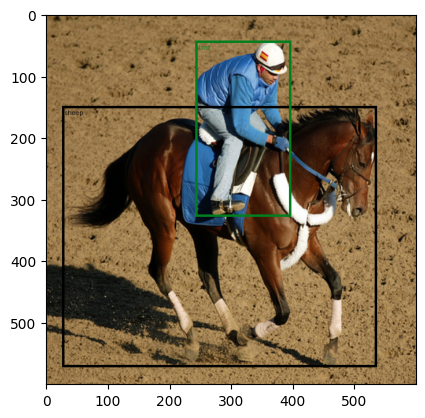

In [ ]:
# Assuming sample[1]['boxes'] contains the bounding boxes
boxes = sample[1]['boxes']

# Convert boxes to (xmin, ymin, xmax, ymax) if they are not already
# If they are in (xmin, ymin, width, height) format
new_boxes = []
for box in boxes:
    xmin = box[0]
    ymin = box[1]
    xmax = xmin + box[2]  # width
    ymax = ymin + box[3]  # height
    new_boxes.append([xmin, ymin, xmax, ymax])

# Convert new_boxes to tensor
boxes = torch.tensor(new_boxes, dtype=torch.float32)

# Draw bounding boxes
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, boxes, [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))
plt.show()

In [ ]:
len(train_dataset)

17125

### Train Model

In [ ]:
# Load the Faster R-CNN model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

In [ ]:
# Training function
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.train()
    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        all_losses.append(losses.item())
        all_losses_dict.append(loss_dict_append)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}".format(epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses)))

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

### Model Testing

In [ ]:
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = Dataset(root=dataset_path, transforms=get_transforms(False))

In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))